In [11]:
import copy
import math
import random
import time
import os
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
from IPython.display import Audio, display
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [3]:
seed = 0
random.seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cpu')

## Load the dataset
Data can be downloaded from http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

In [107]:
data_path = Path('data/speech_commands_v0.01')

testing_hashset = set([
    file_name.strip() for file_name in open(data_path / 'testing_list.txt', 'r')
])
validation_hashset = set([
    file_name.strip() for file_name in open(data_path / 'validation_list.txt', 'r')
])

train_ = []
valid_ = []
test_ = []
for root, _, files in os.walk(data_path):
    if root.endswith('_background_noise_'):
        continue
    root_path = Path(root)
    label = os.path.basename(root)
    for file in files:
        if not file.endswith('.wav'):
            continue
        labelled_file = label + '/' + file
        file_path = root_path / file
        data_entry = {
            'file_path': file_path,
            'label': label
        }
        if labelled_file in testing_hashset:
            test_.append(data_entry)
        elif labelled_file in validation_hashset:
            valid_.append(data_entry)
        else:
            train_.append(data_entry)

print(f'training list has {len(train_)} elements')
print(f'testing list has {len(test_)} elements')
print(f'validation list has {len(valid_)} elements')

training list has 51088 elements
testing list has 6835 elements
validation list has 6798 elements


In [108]:
background_noise_list = []
for root, _, files in os.walk(data_path / '_background_noise_'):
    root_path = Path(root)
    for file in files:
        if not file.endswith('.wav'):
            continue
        data_entry = {
            'file_path': root_path / file,
            'label': file[:-4]
        }
        background_noise_list.append(data_entry)
print(f'background noise files: {[noise['label'] for noise in background_noise_list]}')

background noise files: ['running_tap', 'doing_the_dishes', 'pink_noise', 'exercise_bike', 'white_noise', 'dude_miaowing']


## (optional) Trim the dataset
Use stratified split for stable class distribution

In [109]:
from collections import Counter
from sklearn.model_selection import train_test_split

def get_trimmed_dataset(dataset, trim=0.1, seed=0, verbose=True):
    class_distribution = Counter([entry['label'] for entry in dataset])
    if verbose:
        print(f"Original dataset size: {len(dataset)}")
        print(class_distribution)

    filtered_labels = {label for label, count in class_distribution.items() if count >= 2}
    X = [entry['file_path'] for entry in dataset]
    y = [entry['label'] for entry in dataset]

    X_trimmed, _, y_trimmed, _ = train_test_split(X, y, stratify=y, test_size=(1 - trim), random_state=seed)

    dataset = [{'file_path': entry[0], 'label': entry[1]} for entry in zip(X_trimmed, y_trimmed)]

    if verbose:
        print(f"Trimmed dataset size: {len(dataset)}")
        class_distribution = Counter([entry['label'] for entry in dataset])
        print(class_distribution)

    return dataset

trim_size = 0.2
test_ = get_trimmed_dataset(test_, trim=trim_size, seed=seed)
train_ = get_trimmed_dataset(train_, trim=trim_size, seed=seed)
valid_ = get_trimmed_dataset(valid_, trim=trim_size, seed=seed)

Original dataset size: 6835
Counter({'up': 272, 'five': 271, 'left': 267, 'three': 267, 'two': 264, 'off': 262, 'nine': 259, 'right': 259, 'eight': 257, 'yes': 256, 'four': 253, 'down': 253, 'no': 252, 'go': 251, 'zero': 250, 'stop': 249, 'one': 248, 'on': 246, 'six': 244, 'seven': 239, 'tree': 193, 'sheila': 186, 'dog': 180, 'happy': 180, 'bed': 176, 'cat': 166, 'wow': 165, 'marvin': 162, 'bird': 158, 'house': 150})
Trimmed dataset size: 1367
Counter({'three': 54, 'up': 54, 'five': 54, 'two': 53, 'left': 53, 'right': 52, 'nine': 52, 'off': 52, 'down': 51, 'four': 51, 'eight': 51, 'yes': 51, 'go': 50, 'no': 50, 'one': 50, 'stop': 50, 'zero': 50, 'on': 49, 'six': 49, 'seven': 48, 'tree': 39, 'sheila': 37, 'happy': 36, 'dog': 36, 'bed': 35, 'cat': 33, 'wow': 33, 'marvin': 32, 'bird': 32, 'house': 30})
Original dataset size: 51088
Counter({'one': 1892, 'stop': 1885, 'nine': 1875, 'seven': 1875, 'two': 1873, 'zero': 1866, 'on': 1864, 'six': 1863, 'go': 1861, 'yes': 1860, 'no': 1853, 'right

## Labels preprocessing

In [111]:
id2label = {
    0: 'down',
    1: 'go',
    2: 'left',
    3: 'no',
    4: 'off',
    5: 'on',
    6: 'right',
    7: 'stop',
    8: 'up',
    9: 'yes',
    10: 'unknown'
}

label2id = {label: i for i, label in id2label.items()}

def preprocess_function(instance):
    instance['old_label'] = instance['label'
    instance['label_id'] = label2id.get(instance['label'], label2id['unknown'])
    instance['label'] = id2label[instance['label_id']]
    return instance

train = [preprocess_function(entry) for entry in train_]
test = [preprocess_function(entry) for entry in test_]
valid = [preprocess_function(entry) for entry in valid_]

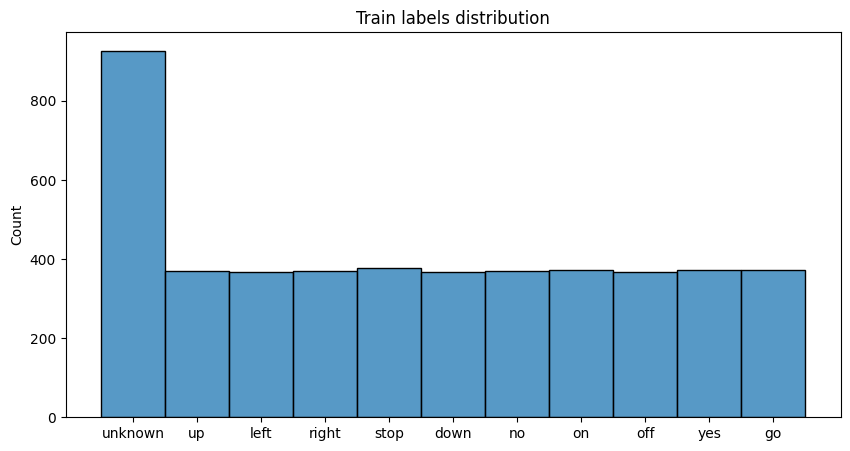

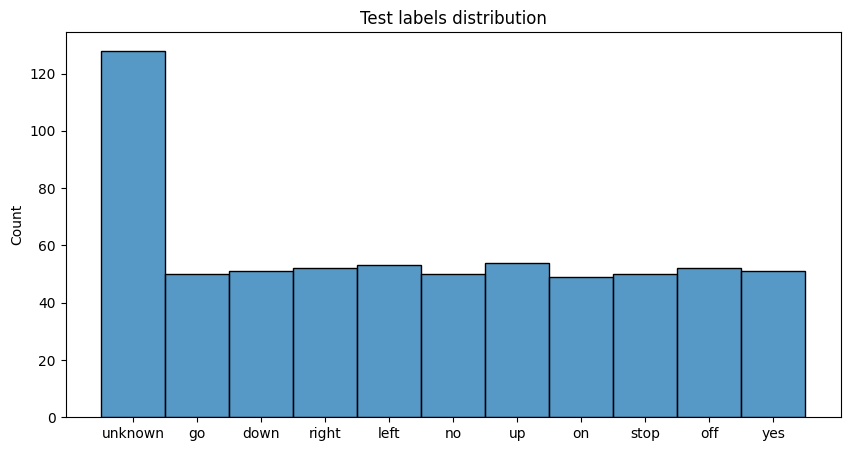

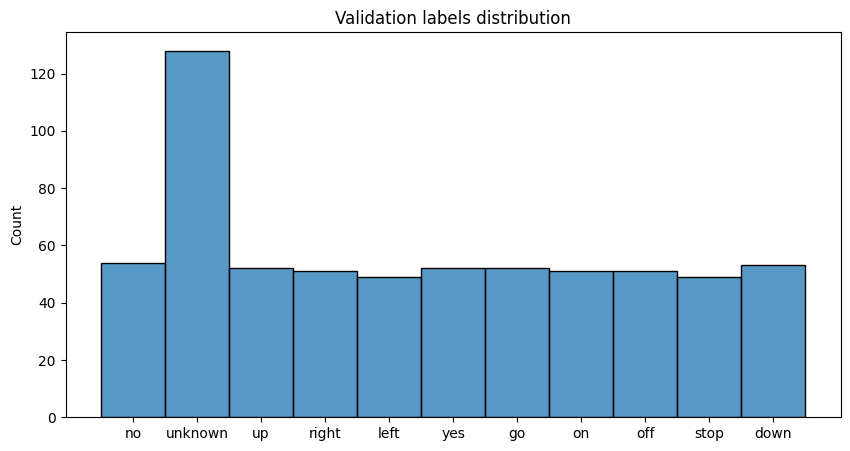

In [126]:
plt.figure(figsize=(10, 5))
sns.histplot([entry['label'] for entry in train])
plt.title("Train labels distribution")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot([entry['label'] for entry in test])
plt.title("Test labels distribution")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot([entry['label'] for entry in valid])
plt.title("Validation labels distribution")
plt.show()

### Reduce unkown label count
There's too many unknown labels, making the dataset unbalanced.

In [125]:
def reduce_unknown_to_target(dataset, target_ratio=0.2):
    total_samples = len(dataset)
    known_samples = len([entry for entry in dataset if entry['label'] != 'unknown'])
    unknown_samples = total_samples - known_samples
    current_ratio = unknown_samples / total_samples
    
    # If current ratio is already lower than target, no need to reduce
    if current_ratio <= target_ratio:
        print(f"No reduction needed. Current unknown ratio: {current_ratio:.2%}")
        return dataset
    
    unknown_to_keep = int(known_samples * target_ratio / (1 - target_ratio))
    
    unknown_indices = [i for i, entry in enumerate(dataset) if entry['label'] == 'unknown']
    indices_to_keep = random.sample(unknown_indices, unknown_to_keep)

    balanced_dataset = [entry for i, entry in enumerate(dataset) 
                        if entry['label'] != 'unknown' or i in indices_to_keep]

    new_total = len(balanced_dataset)
    new_unknown = len([entry for entry in balanced_dataset if entry['label'] == 'unknown'])
    print(f"Original dataset: {total_samples} samples, {unknown_samples} unknown ({unknown_samples/total_samples:.2%})")
    print(f"Balanced dataset: {new_total} samples, {new_unknown} unknown ({new_unknown/new_total:.2%})")
    
    return balanced_dataset

train = reduce_unknown_to_target(train)
test = reduce_unknown_to_target(test)
valid = reduce_unknown_to_target(valid)

No reduction needed. Current unknown ratio: 20.00%
No reduction needed. Current unknown ratio: 20.00%
No reduction needed. Current unknown ratio: 19.94%
